# Implementing a Detection Trial

## Here is our state scheme:
![Detection](https://raw.githubusercontent.com/cdeister/csVisual/master/stateGraphs/detectionStates.png)

[This code needs to be on a teensy](https://github.com/cdeister/csVisual/tree/master/microcontrollerCode/csVisual_DetectionStates)

## This is part 2. We will implement a session with a series of very simple trials. With little else, this will run a detection task. But, there are some other pieces of equipement we want to interact with for a full task, so that will be in part 3. Nevertheless, between part 1 and this, part 2, 99% of how to implement a task should be clear. 

In [1]:
import warnings
warnings.filterwarnings('ignore')

import serial
import numpy as np
%matplotlib notebook
# Inline is jank, but you have to hand code fig nums.
import matplotlib.pyplot as plt
import h5py
import os
import datetime
import time

The way I handle task and session variables. Is to use python dictionaries. I like the data container, in general, but for our purposes they offer only upside. They are easily exported into a pandas data frame for importing later, or feeding larger machine learning routines etc.

If you are not familiar with python data types, you should be:
Places to start:

[general dict cribnotes](https://automatetheboringstuff.com/chapter5/)

[indexing dicts](https://www.saltycrane.com/blog/2007/09/how-to-sort-python-dictionary-by-keys/)



In [2]:
# Let's make two dictionaries. One for session variables, and one for trial stuff.

sesVars={'comPath_teensy':'/dev/cu.usbmodem3650661','baudRate_teensy':115200}

trialVars={'rewardFired':0,'rewardDur':50,'trialNum':0,'trialDur':0,\
'lickLatchA':0,'lickAThr':500,'minNoLickTime':1000}

# note that dictionaries can store anything.

My prefered data container is HDF5. That is its own discussion. For now, it is enough to know that HDF5 files store numerical data in a heirarchical way. Thus, we can have /animal/sessionX/trialX/data scheme.

In [21]:
# Handle hdf5

# You will need to modify the base path.
baseHDFPath='/Users/cad/'  

# Make an HDF file, or open it if it exists
f = h5py.File(baseHDFPath+"{}.hdf".format('teztSubject_BehavData'), "a")

# we will make a sessionX subgroup in the HDF, 
# where X is the number of sessions there +1
exSes=0
for keys in f:
    exSes=exSes+1
curSes=exSes+1
hdfGrp=f.create_group('session_{}'.format(curSes))

# at this point the file is open in our python programs memory scope. 
# we can write to it like it is a disk.
# also best to close when we are done.

In [22]:
# Now let's create some helper functions:
def connectComObj(comPath,baudRate):
    comObj = serial.Serial(comPath,baudRate)
    return comObj


def readSerialData(comObj,headerString,varCount):
    sR=[]
    newData=0
    if comObj.inWaiting()>0:
        sR=comObj.readline().strip().decode()
        sR=sR.split(',')
        if len(sR)==varCount and sR[0]==headerString:
            newData=1
    return sR,newData

def flushBuffer(comObj):
    while comObj.inWaiting()>0:
        sR=comObj.readline().strip().decode()

# These are serial functions and should seem familiar. 

In [23]:
# Make a teensy object by connecting to the main teensy.
teensy=connectComObj(sesVars['comPath_teensy'],sesVars['baudRate_teensy'])
teensyState=-1

In [7]:
# First, let's get Teensy into state 0, in case it isn't

# Send teensy to state 0 and flush the buffer.
flushBuffer(teensy)
teensy.write('a0>'.encode('utf-8'))
time.sleep(0.005)


In [24]:
# double check and force
while teensyState != 0:
    print("not in 0, will force")
    teensy.write('a0>'.encode('utf-8'))
    time.sleep(0.002)
    teensy.write('a<'.encode('utf-8'))
    [tString,dNew]=readSerialData(teensy,'echo',4)
    if dNew:
        if int(tString[1])==0:
            teensyState=int(tString[2])
    elif dNew==0:
        time.sleep(0.002)

not in 0, will force
not in 0, will force
not in 0, will force


In [25]:
# we are going to have to save some timeseries. 
# we set up lists that we will append to here.

# set up trial data handling.
interrupt=[]
trialTime=[]
stateTime=[]
teensyState=[]
lick0_Data=[]
lick1_Data=[]
pythonState=[]
thrLicksA=[]

For this example. We will have some variable timed trials. The trials will go from State 1 and wait there for a period of time and then move on to the reward state. The way the teensy code is set up the built-in LED will come on for a bit. 

In [26]:
# Temp Trial Variability

trialOn=1
trialVars['rewardFired']=0
preTime=np.random.randint(200,2000)
trialVars['rewardDur']=333
randPad=np.random.randint(1000,3000)

In [27]:
trialVars['trialDur']=preTime+trialVars['rewardDur']+randPad
print(trialVars['trialDur']/1000)
trialVars['trialNum']=trialVars['trialNum']+1
print('start trial #{}'.format(trialVars['trialNum']))

3.274
start trial #2


In [28]:
# start pyState at 1, it will rip from there, so explainations later. 
# This block sets it up, next will rip.
pyState=1
lickCo=0  
lastLick=0
stateHeader=0
trialLicks=0
teensy.write('r{}>'.format(trialVars['rewardDur']).encode('utf-8'))
time.sleep(0.002)
# Send to 1, wait state.

In [29]:
# This is a trial. We set the teensy to 1, 
# we check to make sure it is in 1, and add to data etc.

teensy.write('a1>'.encode('utf-8'))  
while trialOn:
    try:
        # 1) Look for data.
        [tString,dNew]=readSerialData(teensy,'tData',7)
        if dNew:
            tInterrupt=int(tString[1])
            tTrialTime=int(tString[2])
            tStateTime=int(tString[3])
            tTeensyState=int(tString[4])
            tLick0=int(tString[5])
            tLick1=int(tString[6])


            interrupt.append(tInterrupt)
            trialTime.append(tTrialTime)
            stateTime.append(tStateTime)
            teensyState.append(tTeensyState)
            lick0_Data.append(tLick0)
            lick1_Data.append(tLick1)
            pythonState.append(pyState)
            thrLicksA.append(0)


            # look for licks
            if tLick0>trialVars['lickAThr'] and trialVars['lickLatchA']==0:
                thrLicksA[-1]=1
                trialVars['lickLatchA']=20
                trialLicks=trialLicks+1
            elif tLick0<=trialVars['lickAThr'] or trialVars['lickLatchA']>0:
                trialVars['lickLatchA']=trialVars['lickLatchA']-1

            # 2) Does pyState match tState?
            if pyState == tTeensyState:
                stateSync=1
            elif pyState != tTeensyState:
                stateSync=0

            # 3) Push state change if off.
            if stateSync==0:
                teensy.write('a{}>'.format(pyState).encode('utf-8'))  

            # 4) Now look at what state you are in and evaluate accordingly
            if pyState == 1 and stateSync==1:
                if thrLicksA[-1] == 1:
                    lickCounter=0
                    lastLick=tStateTime
                if (tStateTime-lastLick)>trialVars['minNoLickTime'] and tStateTime>preTime:
                    stateSync=0
                    pyState=4
                    teensy.write('a4>'.encode('utf-8'))

            if pyState == 4 and stateSync==1:
                if tStateTime>trialVars['rewardDur']+randPad:
                    stateSync=0
                    trialOn=0


    except:
        trialOn=0
        
print('trial done')

trial done


If the teensy didn't blink then something went wrong.

In [30]:
# now we make an HDF 'dataset' that will be all the t-series we collected for this trial.
tNum=trialVars['trialNum']
tNPA=np.zeros([len(interrupt),8])
# it is very easy to make a multidimensional dataset from a numpy array.
tNPA[:,0]=interrupt
tNPA[:,1]=trialTime
tNPA[:,2]=stateTime
tNPA[:,3]=teensyState
tNPA[:,4]=lick0_Data
tNPA[:,5]=lick1_Data
tNPA[:,6]=pythonState
tNPA[:,7]=thrLicksA
hdfGrp['t{}'.format(tNum)]=tNPA

<IPython.core.display.Javascript object>


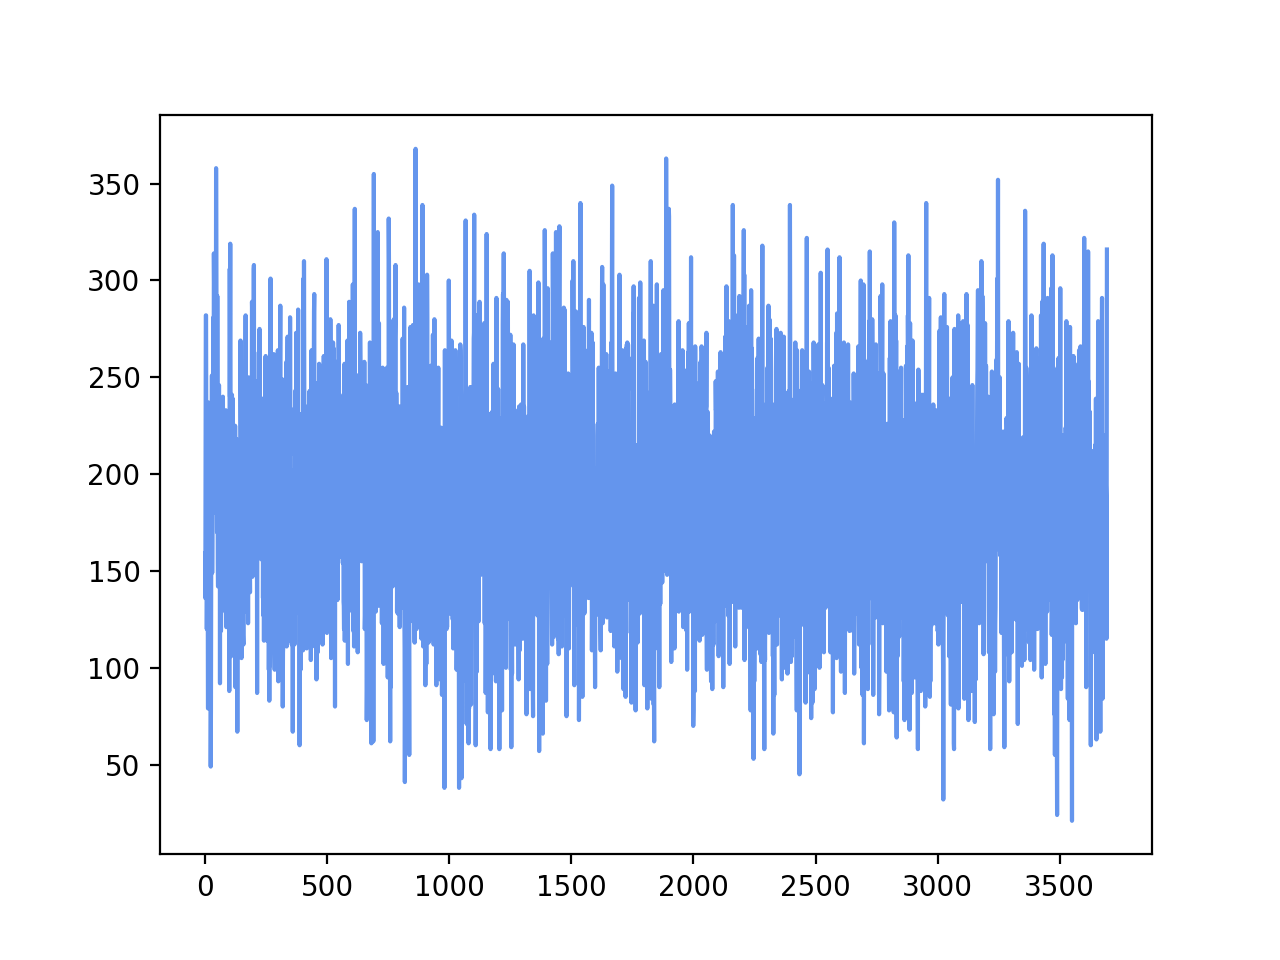

In [31]:
# Couple of ways to look at data. 
#1) We didn't clear our lists so ...
plt.figure(100)
ax1=plt.plot(trialTime,lick0_Data,color='cornflowerblue')

<IPython.core.display.Javascript object>


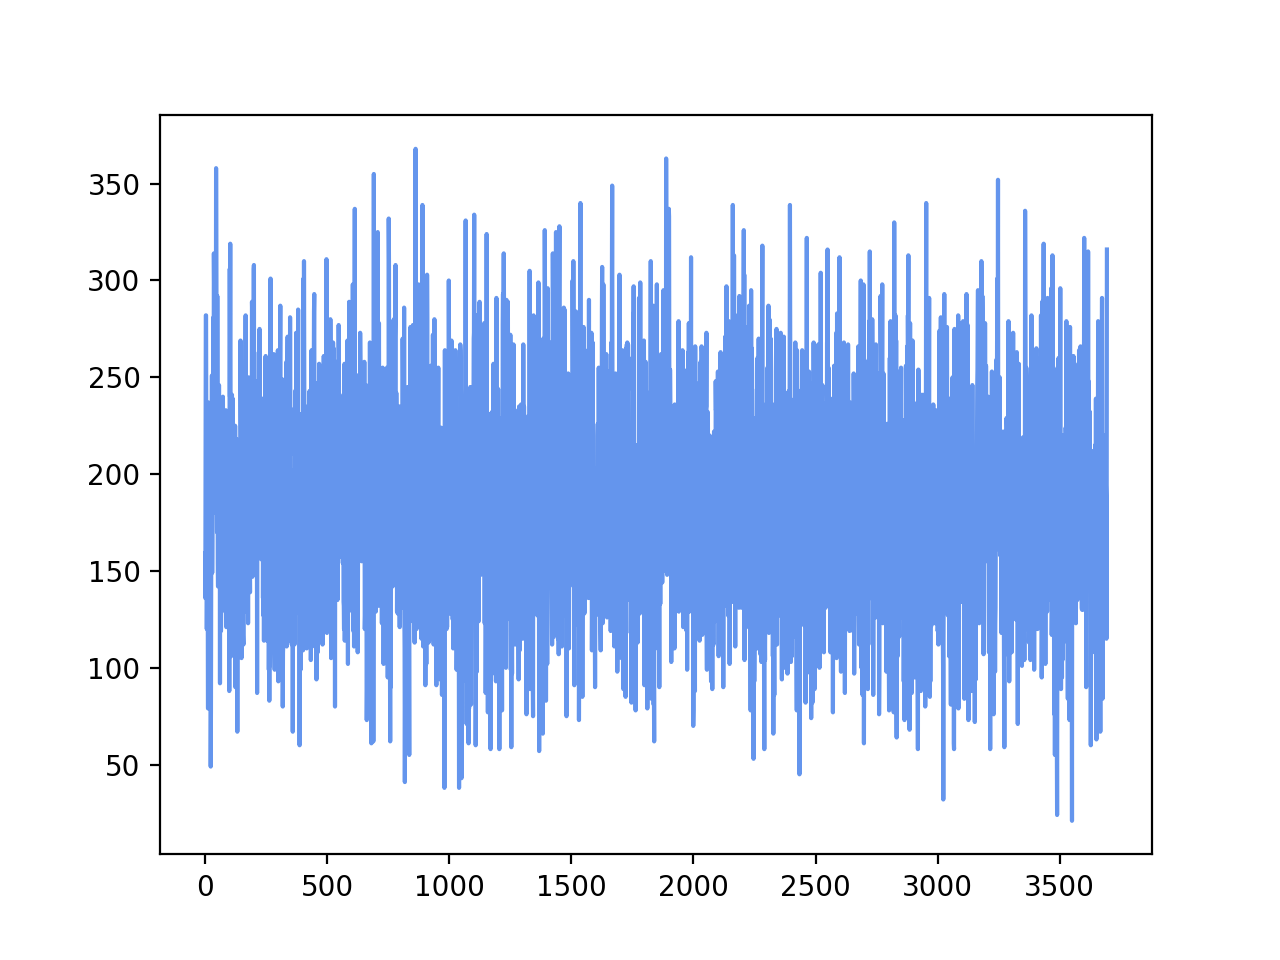

In [52]:
# 2) We can address the HDF directly.
plt.figure(101)
hTime=hdfGrp["/session_2"]["t2"][:,2]
hData=hdfGrp["/session_2"]["t2"][:,7]
ax1=plt.plot(trialTime,lick0_Data,color='cornflowerblue')

In [53]:
# We should now close the hdf file, so other things can access it.
f.close()

We did one trial, but we can loop many, even if they are variable. 
The code below should give you ten trials and save them as you go into the same HDF. If it stays stuck in 0, reset the teensy with the button and try again.

In [55]:
# Handle hdf5
f = h5py.File('/Users/cad/'+"{}_{}.hdf".format('teztHDF','001'), "a")
exSes=0
for keys in f:
    exSes=exSes+1
curSes=exSes+1
hdfGrp=f.create_group('session_{}'.format(curSes))

# Make a teensy object by connecting to the main teensy.
teensy=connectComObj(sesVars['comPath_teensy'],sesVars['baudRate_teensy'])
teensyState=-1

# Send teensy to state 0 and flush the buffer.
flushBuffer(teensy)
teensy.write('a0>'.encode('utf-8'))
time.sleep(0.005)


while trialVars['trialNum']<10:

    # Go ahead and check the state:
    teensy.write('a<'.encode('utf-8'))
    time.sleep(0.005)
    [tString,dNew]=readSerialData(teensy,'echo',4)
    if dNew:
        if int(tString[1])==0:
            teensyState=int(tString[2])

    while teensyState != 0:
        print("not in 0, will force)")
        teensy.write('a0>'.encode('utf-8'))
        time.sleep(0.005)
        teensy.write('a<'.encode('utf-8'))
        [tString,dNew]=readSerialData(teensy,'echo',4)
        if dNew:
            if int(tString[1])==0:
                teensyState=int(tString[2])
        elif dNew==0:
            time.sleep(0.005)

    # set up trial data handling.
    interrupt=[]
    trialTime=[]
    stateTime=[]
    teensyState=[]
    lick0_Data=[]
    lick1_Data=[]
    pythonState=[]
    thrLicksA=[]


    # Temp Trial Variability
    trialOn=1
    trialVars['rewardFired']=0
    preTime=np.random.randint(200,2000)
    trialVars['rewardDur']=333
    randPad=np.random.randint(1000,3000)

    trialVars['trialDur']=preTime+trialVars['rewardDur']+randPad
    print(trialVars['trialDur']/1000)
    trialVars['trialNum']=trialVars['trialNum']+1
    print('start trial #{}'.format(trialVars['trialNum']))

    # start pyState at 1

    pyState=1
    lickCo=0  
    lastLick=0
    stateHeader=0
    trialLicks=0
    teensy.write('r{}>'.format(trialVars['rewardDur']).encode('utf-8'))
    time.sleep(0.002)
    # Send to 1, wait state.
    teensy.write('a1>'.encode('utf-8'))  


    while trialOn:
        try:
            # 1) Look for data.
            [tString,dNew]=readSerialData(teensy,'tData',7)
            if dNew:
                tInterrupt=int(tString[1])
                tTrialTime=int(tString[2])
                tStateTime=int(tString[3])
                tTeensyState=int(tString[4])
                tLick0=int(tString[5])
                tLick1=int(tString[6])


                interrupt.append(tInterrupt)
                trialTime.append(tTrialTime)
                stateTime.append(tStateTime)
                teensyState.append(tTeensyState)
                lick0_Data.append(tLick0)
                lick1_Data.append(tLick1)
                pythonState.append(pyState)
                thrLicksA.append(0)


                # look for licks
                if tLick0>trialVars['lickAThr'] and trialVars['lickLatchA']==0:
                    thrLicksA[-1]=1
                    trialVars['lickLatchA']=20
                    trialLicks=trialLicks+1
                elif tLick0<=trialVars['lickAThr'] or trialVars['lickLatchA']>0:
                    trialVars['lickLatchA']=trialVars['lickLatchA']-1

                # 2) Does pyState match tState?
                if pyState == tTeensyState:
                    stateSync=1
                elif pyState != tTeensyState:
                    stateSync=0

                # 3) Push state change if off.
                if stateSync==0:
                    teensy.write('a{}>'.format(pyState).encode('utf-8'))  

                # 4) Now look at what state you are in and evaluate accordingly
                if pyState == 1 and stateSync==1:
                    if thrLicksA[-1] == 1:
                        lickCounter=0
                        lastLick=tStateTime
                    if (tStateTime-lastLick)>trialVars['minNoLickTime'] and tStateTime>preTime:
                        stateSync=0
                        pyState=4
                        teensy.write('a4>'.encode('utf-8'))

                if pyState == 4 and stateSync==1:
                    if tStateTime>trialVars['rewardDur']+randPad:
                        stateSync=0
                        trialOn=0


        except:
            trialOn=0


    tNum=trialVars['trialNum']
    tNPA=np.zeros([len(interrupt),8])
    tNPA[:,0]=interrupt
    tNPA[:,1]=trialTime
    tNPA[:,2]=stateTime
    tNPA[:,3]=teensyState
    tNPA[:,4]=lick0_Data
    tNPA[:,5]=lick1_Data
    tNPA[:,6]=pythonState
    tNPA[:,7]=thrLicksA
    hdfGrp['t{}'.format(tNum)]=tNPA

    teensy.write('a0>'.encode('utf-8'))
    time.sleep(0.001)
    
print('finished session')

not in 0, will force)
not in 0, will force)
not in 0, will force)
not in 0, will force)
not in 0, will force)
not in 0, will force)
not in 0, will force)
not in 0, will force)
not in 0, will force)
not in 0, will force)
not in 0, will force)
not in 0, will force)
not in 0, will force)
not in 0, will force)
not in 0, will force)
not in 0, will force)
not in 0, will force)
not in 0, will force)
not in 0, will force)
not in 0, will force)
not in 0, will force)
not in 0, will force)
not in 0, will force)
not in 0, will force)
not in 0, will force)
not in 0, will force)
not in 0, will force)
not in 0, will force)
not in 0, will force)
not in 0, will force)
not in 0, will force)
not in 0, will force)
not in 0, will force)
not in 0, will force)
not in 0, will force)
not in 0, will force)
not in 0, will force)
not in 0, will force)
not in 0, will force)
not in 0, will force)
not in 0, will force)
not in 0, will force)
not in 0, will force)
not in 0, will force)
not in 0, will force)
not in 0, 

In [56]:
f.close()
teensy.close()
